In [ ]:
# Dengue Predictions with Poisson Model, B

## Introduction
This Jupyter notebook embarks on a statistical journey to unravel the complexities of dengue fever predictions. Dengue, a mosquito-borne viral infection, poses significant public health challenges across various tropical and subtropical regions worldwide. Predictive modeling of dengue incidences is crucial for effective disease surveillance and control strategies. This notebook utilizes the Poisson regression model, a popular choice for count data, to predict dengue cases. Given the potential for overdispersion in such data, where variance exceeds the mean, the analysis rigorously tests for this phenomenon using the overdisp function. Understanding overdispersion is vital for ensuring the reliability of predictive models, as it can significantly affect the interpretation of model coefficients and the accuracy of predicted values.

### Import the libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
from scipy import stats 
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

### Import the data

In [3]:
df_dengue = pd.read_csv("dengue.txt", delimiter=';')
df_febre = pd.read_csv("febre.txt", delimiter=';' )

df_dengue.head()

,Unidade da Federação,Taxa de incidência
0,Rondônia,"205,03"
1,Acre,"306,15"
2,Amazonas,"149,54"
3,Roraima,"390,40"
4,Pará,"205,50"


In [4]:
df_febre.head()

,Unidade da Federação,Casos confirmados
0,Rondônia,9
1,Amazonas,17
2,Roraima,1
3,Pará,31
4,Amapá,6


### Merge the datasets

In [5]:
df = pd.merge(df_dengue, df_febre, on="Unidade da Federação")

# Organizing the data
df['Casos confirmados'] = df['Casos confirmados'].astype(float)
df["Taxa de incidência"] = df["Taxa de incidência"].str.replace(',', '.').astype(float)

df = df.sort_values(by="Taxa de incidência", ascending=True, ignore_index=True)

# Rename columns
df.rename(columns={"Casos confirmados": "febre", "Taxa de incidência": "taxa"}, inplace=True)

df.head()

,Unidade da Federação,taxa,febre
0,Paraná,45.05,1.0
1,Distrito Federal,55.96,1.0
2,São Paulo,68.35,39.0
3,Maranhão,78.97,16.0
4,Amazonas,149.54,17.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unidade da Federação  24 non-null     object 
 1   taxa                  24 non-null     float64
 2   febre                 24 non-null     float64
dtypes: float64(2), object(1)
memory usage: 708.0+ bytes


In [7]:
df.isnull().sum()

Unidade da Federação    0
taxa                    0
febre                   0
dtype: int64

In [8]:
df.describe()

,taxa,febre
count,24.000000,24.000000
mean,396.944167,44.291667
std,318.055990,43.064642
min,45.050000,1.000000
25%,193.267500,16.750000
50%,334.270000,32.500000
75%,463.242500,62.250000
max,1100.650000,159.000000


### Chart

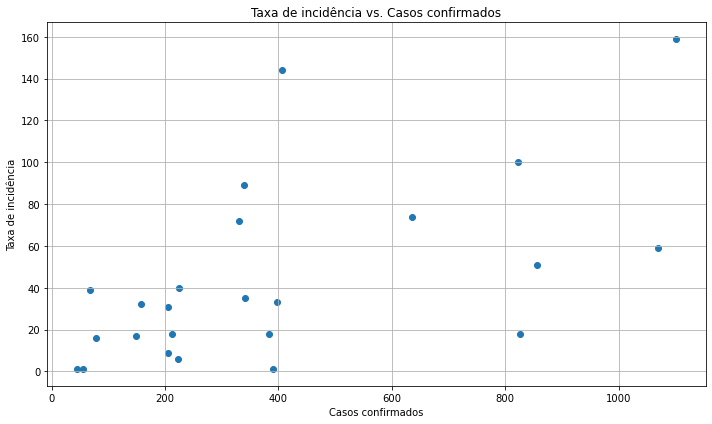

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(df["taxa"], df["febre"])
plt.xlabel("Casos confirmados")
plt.ylabel("Taxa de incidência")
plt.title("Taxa de incidência vs. Casos confirmados")
plt.grid(True)
plt.tight_layout()

plt.show()

### Poisson model estimation

### CAMERON AND TRIVEDI SUPERDISPERSION TEST (1990)
### CAMERON, A. C.; TRIVEDI, P. K. Regression-based tests for overdispersion in the Poisson model. Journal of Econometrics, v. 46, n. 3, p. 347-364, 1990.

In [10]:
modelo_poisson = smf.glm(formula='taxa ~ febre',
                         data=df,
                         family=sm.families.Poisson()).fit()

# Model parameters
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   taxa   No. Observations:                   24
Model:                            GLM   Df Residuals:                       22
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2011.9
Date:                Wed, 10 Apr 2024   Deviance:                       3844.4
Time:                        00:26:10   Pearson chi2:                 4.18e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5244      0.016    340.088      0.000       5.493       5.556
febre          0.0086      0.000     43.443      0.000       0.008       0.009
==============================================================================
"""

### Adding the fitted values ​​of the Poisson model (lambda_poisson) to the dataframe:

In [11]:
df['lambda_poisson'] = modelo_poisson.fittedvalues

# Creating the new variable Y*:
df['ystar'] = (((df['febre'] -df['lambda_poisson'])**2) -df['febre'])/df['lambda_poisson']

# Estimating the auxiliary OLS model, without the intercept:
modelo_auxiliar = smf.ols(formula='ystar ~ 0 + lambda_poisson',
                          data=df).fit()

# Parameters of 'modelo_auxiliar'
modelo_auxiliar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  ystar   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              1824.
Date:                Wed, 10 Apr 2024   Prob (F-statistic):                    2.06e-23
Time:                        00:26:12   Log-Likelihood:                         -120.82
No. Observations:                  24   AIC:                                      243.6
Df Residuals:                      23   BIC:                                      244.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
lambda_poisson     0.7562      0.018     42.714      0.000       0.720       0.793
==============================================================================
Omnibus:                        2.217   Durbin-Watson:                   0.859
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                1.710
Skew:                          -0.492   Prob(JB):                        0.425
Kurtosis:                       2.138   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 'overdisp' function

In [11]:
from statstests.tests import overdisp

# Direct elaboration of the overdispersion test
overdisp(modelo_poisson, df)

Estimating model...: 
 GLM
                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.191   
Dependent Variable:     ystar            AIC:                         341.4182
Date:                   2023-10-07 00:30 BIC:                         342.5962
No. Observations:       24               Log-Likelihood:              -169.71 
Df Model:               1                F-statistic:                 6.684   
Df Residuals:           23               Prob (F-statistic):          0.0165  
R-squared (uncentered): 0.225            Scale:                       84720.  
-----------------------------------------------------------------------------------
               Coef.       Std.Err.        t         P>|t|       [0.025      0.975]
-----------------------------------------------------------------------------------
lmbda          0.3510        0.1358      2.5853      0.0165      0.0701      0.6318
-----------------------------

### Estimation of the negative binomial model of type NB2

In [12]:
modelo_bneg = smf.glm(formula='taxa ~ febre',
                      data=df,
                      family=sm.families.NegativeBinomial(alpha=2.0963)).fit()

# Model parameters
modelo_bneg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   taxa   No. Observations:                   24
Model:                            GLM   Df Residuals:                       22
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -173.03
Date:                Wed, 10 Apr 2024   Deviance:                       5.8344
Time:                        00:26:17   Pearson chi2:                     5.90
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08254
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4402      0.429     12.681      0.000       4.599       6.281
febre          0.0102      0.007      1.459      0.145      -0.004       0.024
==============================================================================
"""

### Construction of a function to define the optimal 'alpha' ('fi') that generates the maximization of the Log-Likelihood value

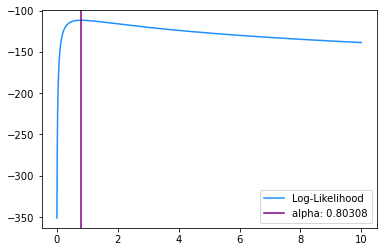

In [13]:
n_samples = 10000
alphas = np.linspace(0, 10, n_samples)
llf = np.full(n_samples, fill_value=np.nan)
for i, alpha in enumerate(alphas):
    try:
        model = smf.glm(formula = 'febre ~ taxa',
                        data=df,
                        family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    except:
        continue
    llf[i] = model.llf
alpha_optim = alphas[np.nanargmax(llf)]

#Plotagem dos resultados
plt.plot(alphas, llf, label='Log-Likelihood', color='dodgerblue')
plt.axvline(x=alpha_optim, color='purple',
            label=f'alpha: {alpha_optim:0.5f}')
plt.legend()

### Reestimation of the negative binomial model with the 'alpha_optim' parameter

In [15]:
modelo_bneg = smf.glm(formula='febre ~ taxa',
                      data=df,
                      family=sm.families.NegativeBinomial(alpha=alpha_optim)).fit()

# Model parameters
modelo_bneg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  febre   No. Observations:                   24
Model:                            GLM   Df Residuals:                       22
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -111.67
Date:                Wed, 10 Apr 2024   Deviance:                       27.053
Time:                        00:27:26   Pearson chi2:                     20.9
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2883
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9528      0.303      9.750      0.000       2.359       3.546
taxa           0.0018      0.001      2.955      0.003       0.001       0.003
==============================================================================
"""

### Comparing Poisson and Negative Binomial Models

In [16]:
summary_col([modelo_poisson, modelo_bneg], 
            model_names=["Poisson","BNeg"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf),
                'Pseudo-R2':lambda x: "{:.4f}".format(x.pseudo_rsquared()),
        })

,Poisson,BNeg
Intercept,5.5244***,2.9528***
,(0.0162),(0.3028)
febre,0.0086***,
,(0.0002),
taxa,,0.0018***
,,(0.0006)
N,24,24
Log-lik,-2011.90,-111.67
Pseudo-R2,1.0000,0.2883


### Likelihood ratio test to compare LL's between models

In [17]:
# Definition of the 'lrtest' function
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1)
    return round(LR_statistic,2), round(p_val,2)

lrtest([modelo_poisson, modelo_bneg])

(3800.46, 0.0)

### Chart for comparing the LL of the Poisson and negative binomial models

Text(0.5, 0, 'Log-Likehood')

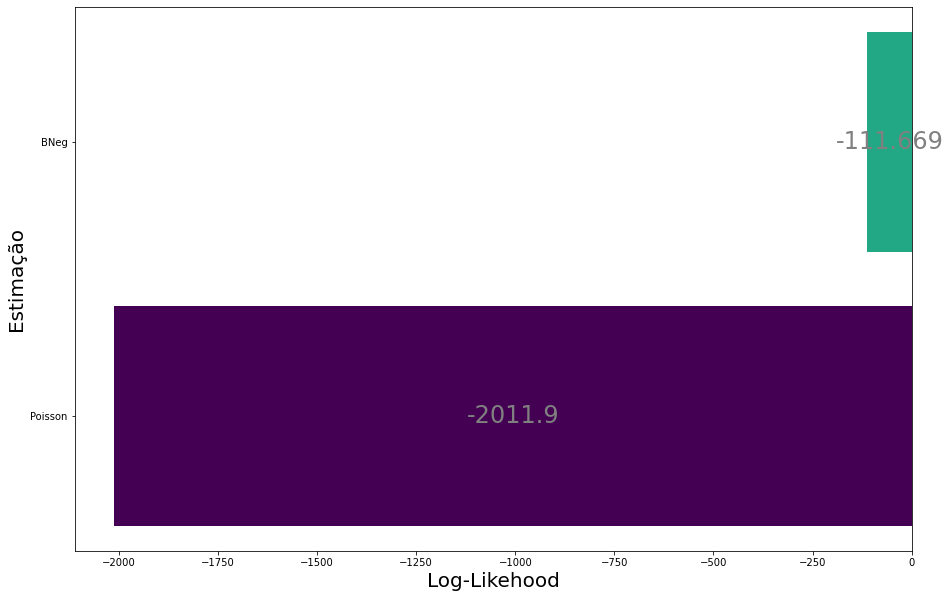

In [18]:
# Definition of the dataframe with the models and respective LL
df_llf = pd.DataFrame({'modelo':['Poisson','BNeg'],
                      'loglik':[modelo_poisson.llf, modelo_bneg.llf]})
df_llf

# Plotagem propriamente dita
fig, ax = plt.subplots(figsize=(15,10))

c = ['#440154FF', '#22A884FF']

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='gray', fontsize=24)
ax.set_ylabel("Estimação", fontsize=20)
ax.set_xlabel("Log-Likehood", fontsize=20)

## Conclusion

In conclusion, the analysis performed in this notebook provides critical insights into the predictive modeling of dengue fever cases. 
Through the application of the Poisson regression model and the subsequent overdispersion test, the study highlights the complexities 
involved in accurately predicting disease incidences. Identifying overdispersion and addressing it ensures that the predictive model 
is robust and reliable, enhancing its utility for public health officials in planning and intervention efforts. Future research may explore
alternative models or methods to manage overdispersion and improve prediction accuracy, ultimately contributing to more effective dengue control
and prevention strategies.